## MACS 30250 PS2
### Dr. Richard W. Evans, TA Zunda Xu
### Submitted by Junho Choi

### Problem 1

Let us first set some variables that will be used throughout the problem set.

In [2]:
import numpy as np
import scipy.optimize as opt
import scipy.interpolate as intpl
import matplotlib.pyplot as plt

In [3]:
eps_vec = np.array([-1.4, -0.55, 0.0, 0.55, 1.4])
pi_vec = np.array([0.1, 0.2, 0.4, 0.2, 0.1])
pi_mat = np.array([[0.4, 0.28, 0.18, 0.1, 0.04],
                   [0.2, 0.40, 0.20, 0.13, 0.07],
                   [0.1, 0.20, 0.40, 0.20, 0.10],
                   [0.07, 0.13, 0.20, 0.40, 0.20],
                   [0.04, 0.10, 0.18, 0.28, 0.40]])

Let us also define some functions that will be used throughout the problem set, especially the CRRA utility function as well as the objective function in the minimization problems. Note that the minimization approach will be done simply by multiplying $-1$ to the maximization objective function. 

In [4]:
def util_CRRA(x, gamma):
    '''
    CRRA utility function taking in two variables,
    x (the amount of consumption) and gamma (parameter).
    '''
    
    one_minus_gamma = 1 - gamma
    rtnval = x ** one_minus_gamma - 1
    rtnval = rtnval / one_minus_gamma
    
    return rtnval

In [5]:
def neg_obj_V(Wp, *args):
    '''
    negative of the original objective function in the maximization problem,
    which takes in Wp (W prime) and various arguments (*args). *args will be
    expanded as follows: W, eps (epsilon value), u_fn (utility function to be used),
    interp_fn (fn for interpolation), 
    '''
    W, eps, u_fn, interp_fn, gamma, beta = args
    c = W - Wp
    V_tp1 = np.exp(eps) * u_fn(c, gamma) + beta * interp_fn(Wp)
    neg_V_tp1 = -V_tp1
    
    return neg_V_tp1

#### Problem 1-(a)

We first set the values of $\beta$, $\gamma$, and the vector of $W$ we will use (30 equally-spaced points from 0.1 to 10).

In [6]:
beta = 0.9
gamma = 2.2
W_vec = np.linspace(0.1, 10, 30)
W_len = len(W_vec)
eps_len = len(eps_vec)

Let us also initialize some of the parameters for value function iteration and convergence.

In [7]:
V_init = np.zeros((W_len, eps_len))
V_update = V_init.copy()

Vfn_dist = 10
Vfn_mindist = 1e-8
Vfn_maxiter = 300

Now let us implement the value function iteration process (loop). For the sake of brevity, we only print every 10th iteration.

In [8]:
for Vfn_iter in range(1, Vfn_maxiter+1):
    if Vfn_dist < Vfn_mindist:
        break
    
    V_init = V_update.copy() ## new repeat; new one as the old one
    V_update = np.zeros((W_len, eps_len)) ## the "new" new vector
    psi_mat = np.zeros((W_len, eps_len)) ## policy fn values psi(W, epsilon)
    
    E_V = V_init @ pi_vec.reshape((eps_len, 1))
    E_V_interp = intpl.interp1d(W_vec, E_V.flatten(), kind='cubic',
                                fill_value='extrapolate')
    
    for eps_ind in range(eps_len):
        for W_ind in range(W_len):
            W_val = W_vec[W_ind]
            eps_val = eps_vec[eps_ind]
            V_args = (W_val, eps_val, util_CRRA,
                      E_V_interp, gamma, beta)
            opt_result = opt.minimize_scalar(neg_obj_V, bounds=(1e-10, W_val - 1e-10),
                                             args=V_args, method='bounded')
            V_update[W_ind, eps_ind] = -opt_result.fun
            psi_mat[W_ind, eps_ind] = opt_result.x
    
    Vfn_dist = ((V_init - V_update) ** 2).sum()
    if Vfn_iter % 10 == 0:
        print("{}th iteration, distance: {}".format(Vfn_iter, Vfn_dist))

10th iteration, distance: 5436.089591828773
20th iteration, distance: 1932.1399178953566
30th iteration, distance: 436.49195996903325
40th iteration, distance: 76.57766324533972
50th iteration, distance: 10.56143149616101
60th iteration, distance: 1.197045463278708
70th iteration, distance: 0.13256302627420297
80th iteration, distance: 0.015917236304857023
90th iteration, distance: 0.001985869936880416
100th iteration, distance: 0.00024472749356697053
110th iteration, distance: 2.9648381687871875e-05
120th iteration, distance: 3.5833367769194124e-06
130th iteration, distance: 4.352039712168657e-07
140th iteration, distance: 5.299492521132884e-08


Final iteration is the 148th one; this concludes Problem 1-(a).

In [9]:
print("Final iteration: {}, distance: {}".format(Vfn_iter-1, Vfn_dist))

Final iteration: 148, distance: 9.828523816404611e-09


#### Problem 1-(b) and Problem 1-(c)

In the below code chunk, I produce both the plot for equilibrium value function as well as that for equilibrium policy function. These values are currently stored in `V_update` and `psi_mat`, respectively.

In [10]:
## transposing for graphing's sake
V_mat_transp = V_update.transpose()
psi_mat_transp = psi_mat.transpose()

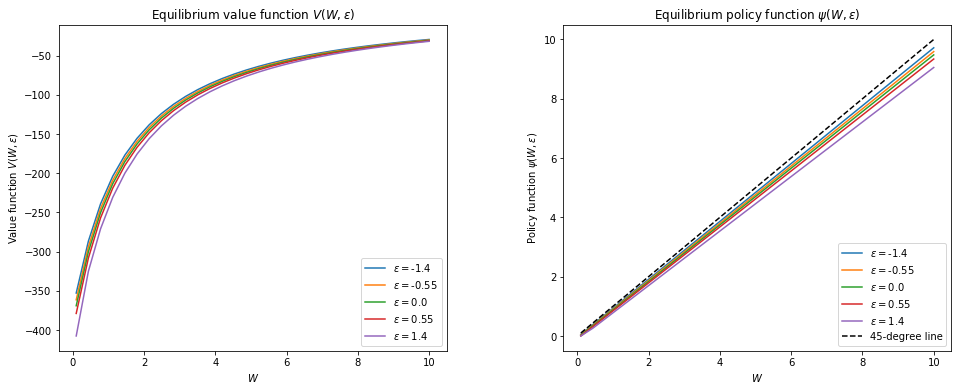

In [11]:
fig_prob_one = plt.figure(figsize=(16, 6))
fig_prob_one.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    
    if i == 0:
        what_to_plot = V_mat_transp
        title = r"Equilibrium value function $V(W, \epsilon)$"
        ylab = r"Value function $V(W, \epsilon)$"
    else:
        what_to_plot = psi_mat_transp
        title = r"Equilibrium policy function $\psi(W, \epsilon)$"
        ylab = r"Policy function $\psi(W, \epsilon)$"
    
    for j in range(eps_len):
        plt.plot(W_vec, what_to_plot[j],
                 label=r"$\epsilon =${}".format(eps_vec[j]))
    
    if i == 1:
        plt.plot(W_vec, W_vec, label="45-degree line",
                 linestyle='--', color='black')
    
    plt.title(title)
    plt.xlabel(r"$W$")
    plt.ylabel(ylab)
    plt.legend(loc="lower right")

plt.show()

This concludes sub-problems 1-(b) and 1-(c).

### Problem 2

#### Problem 2-(a)

Let us initialize some variables for conducting dynamic programming.Note that we alter the maximum number of iterations, just in case.

In [12]:
V_init_ar1 = np.zeros((W_len, eps_len))
V_update_ar1 = V_init_ar1.copy()

Vfn_dist = 10
Vfn_maxiter = 500

We use the following process to conduct dynamic programming for the $AR(1)$ case. Note that for the sake of brevity, the iteration is printed only every 10th iteration.

In [13]:
for Vfn_iter in range(1, Vfn_maxiter+1):
    if Vfn_dist < Vfn_mindist:
        break
    
    V_init_ar1 = V_update_ar1.copy() ## new repeat; new one as the old one
    V_update_ar1 = np.zeros((W_len, eps_len)) ## the "new" new vector
    psi_mat_ar1 = np.zeros((W_len, eps_len)) ## policy fn values psi(W, epsilon)
    
    for eps_ind in range(eps_len):
        which_eps_pi_vec = pi_mat[eps_ind, :]
        E_V_ar1 = V_init_ar1 @ which_eps_pi_vec.reshape((eps_len, 1))
        E_V_interp_ar1 = intpl.interp1d(W_vec, E_V_ar1.flatten(),
                                        kind='cubic', fill_value='extrapolate')

        for W_ind in range(W_len):
            W_val = W_vec[W_ind]
            eps_val = eps_vec[eps_ind]
            V_args = (W_val, eps_val, util_CRRA,
                      E_V_interp_ar1, gamma, beta)
            opt_result_ar1 = opt.minimize_scalar(
                neg_obj_V, bounds=(1e-10, W_val - 1e-10),
                args=V_args, method='bounded')
            V_update_ar1[W_ind, eps_ind] = -opt_result_ar1.fun
            psi_mat_ar1[W_ind, eps_ind] = opt_result_ar1.x
    
    Vfn_dist = ((V_init_ar1 - V_update_ar1) ** 2).sum()
    if Vfn_iter % 10 == 0:
        print("{}th iteration, distance: {}".format(Vfn_iter, Vfn_dist))

10th iteration, distance: 6169.1406209651495
20th iteration, distance: 2160.226185380022
30th iteration, distance: 491.6940988700014
40th iteration, distance: 87.81172046180257
50th iteration, distance: 12.622804626461793
60th iteration, distance: 1.5198717034270297
70th iteration, distance: 0.1722005119778186
80th iteration, distance: 0.020170097655957134
90th iteration, distance: 0.002456676588287505
100th iteration, distance: 0.0003022107274348638
110th iteration, distance: 3.694575250315975e-05
120th iteration, distance: 4.488981554729524e-06
130th iteration, distance: 5.446819409503238e-07
140th iteration, distance: 6.616508737514193e-08


Final iteration is the 149th one; this concludes Problem 2-(a).

In [14]:
print("Final iteration: {}, distance: {}".format(Vfn_iter-1, Vfn_dist))

Final iteration: 149, distance: 9.932174943106485e-09


#### Problem 2-(b) and Problem 2-(c)

In the below code chunk, I produce both the plot for equilibrium value function as well as that for equilibrium policy function; the process is very similar to that in Problem 1.

In [15]:
## transposing for graphing's sake
V_mat_transp_ar1 = V_update_ar1.transpose()
psi_mat_transp_ar1 = psi_mat_ar1.transpose()

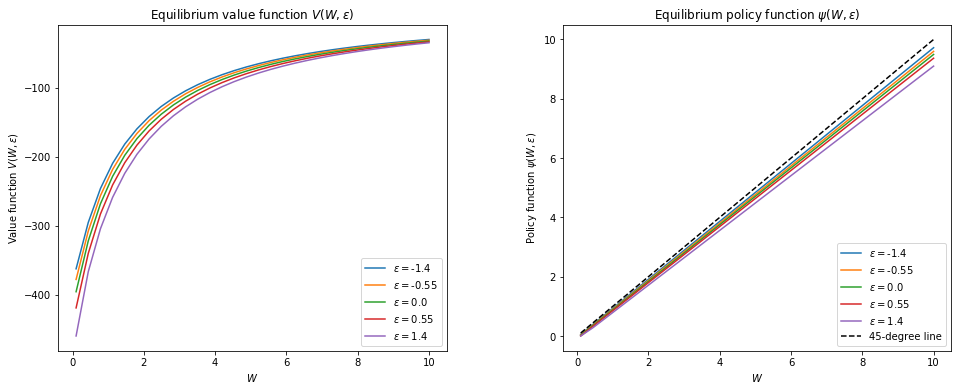

In [16]:
fig_prob_one = plt.figure(figsize=(16, 6))
fig_prob_one.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    
    if i == 0:
        what_to_plot = V_mat_transp_ar1
        title = r"Equilibrium value function $V(W, \epsilon)$"
        ylab = r"Value function $V(W, \epsilon)$"
    else:
        what_to_plot = psi_mat_transp_ar1
        title = r"Equilibrium policy function $\psi(W, \epsilon)$"
        ylab = r"Policy function $\psi(W, \epsilon)$"
    
    for j in range(eps_len):
        plt.plot(W_vec, what_to_plot[j],
                 label=r"$\epsilon =${}".format(eps_vec[j]))
    
    if i == 1:
        plt.plot(W_vec, W_vec, label="45-degree line",
                 linestyle='--', color='black')
    
    plt.title(title)
    plt.xlabel(r"$W$")
    plt.ylabel(ylab)
    plt.legend(loc="lower right")

plt.show()

This concludes the problem set.